# Importing libraries and dataset

In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

from scipy import stats

In [2]:
df = pd.read_csv("tips (data for regression problem).csv")

# EDA

In [3]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [4]:
pd.crosstab(df["day"], df["time"])

time,Dinner,Lunch
day,,
Fri,12,7
Sat,87,0
Sun,76,0
Thur,1,61


In [5]:
df["tip_percentage"] = (df["tip"]/df["total_bill"]*100).round(2)

In [6]:
df.describe()

,total_bill,tip,size,tip_percentage
count,244.000000,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672,16.079754
std,8.902412,1.383638,0.951100,6.107020
min,3.070000,1.000000,1.000000,3.560000
25%,13.347500,2.000000,2.000000,12.910000
50%,17.795000,2.900000,2.000000,15.475000
75%,24.127500,3.562500,3.000000,19.147500
max,50.810000,10.000000,6.000000,71.030000


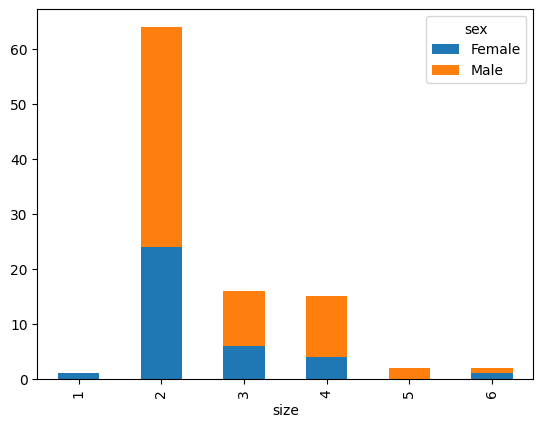

In [7]:
(pd.crosstab(df["size"], df["sex"], normalize="all").round(2)*100).plot(kind='bar', stacked=True);

<Axes: >

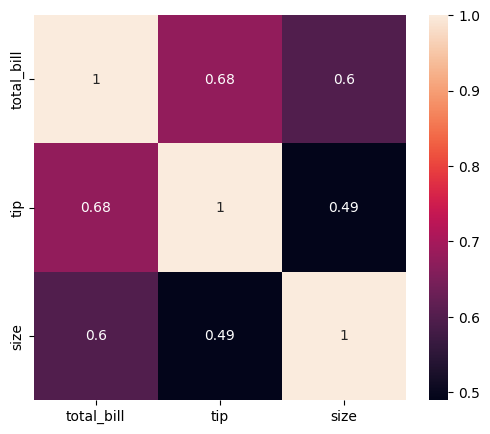

In [8]:
plt.figure(figsize=(6, 5))
sns.heatmap(df[["total_bill", "tip", "size"]].corr(), annot=True)

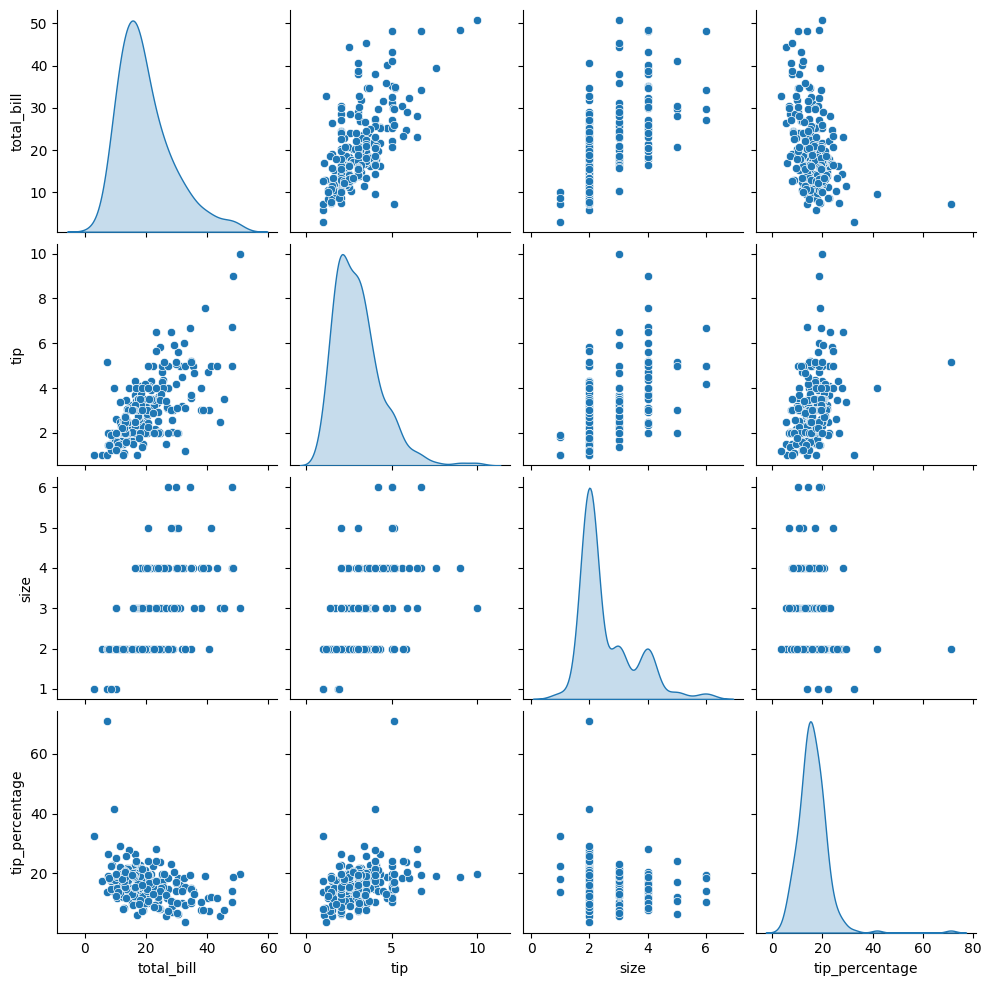

In [9]:
sns.pairplot(df, diag_kind="kde");

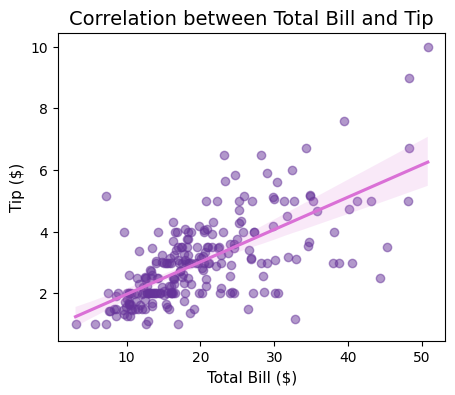

In [10]:
plt.figure(figsize=(5, 4))
sns.regplot(
    x='total_bill', 
    y='tip', 
    data=df, 
    scatter_kws={'alpha':0.5, 'color': 'rebeccapurple'},  
    line_kws={'color': 'orchid'} 
)

plt.title('Correlation between Total Bill and Tip', fontsize=14, )
plt.xlabel('Total Bill ($)', fontsize=11)
plt.ylabel('Tip ($)', fontsize=11)
plt.show()

In [11]:
df["sex"].value_counts()

sex
Male      157
Female     87
Name: count, dtype: int64

In [12]:
df["time"].value_counts()

time
Dinner    176
Lunch      68
Name: count, dtype: int64

In [13]:
df["day"].value_counts()

day
Sat     87
Sun     76
Thur    62
Fri     19
Name: count, dtype: int64

<Axes: xlabel='sex', ylabel='tip'>

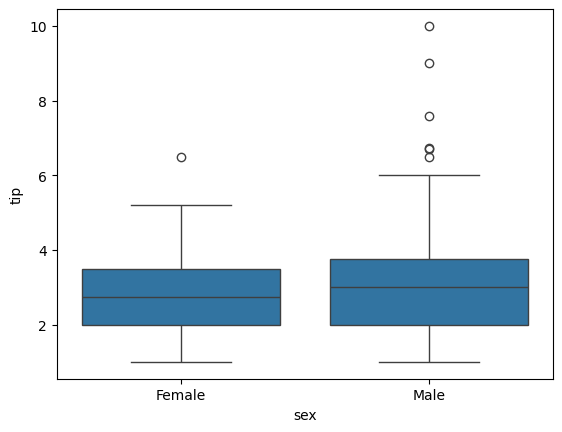

In [14]:
sns.boxplot(data=df, x="sex", y="tip")

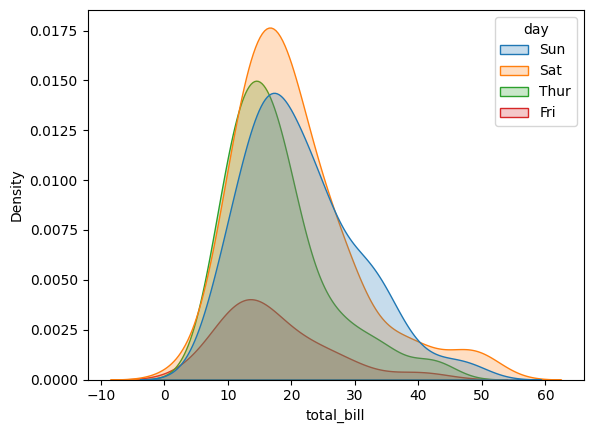

In [15]:
# sns.kdeplot(data=df, x="total_bill", hue="sex", fill=True);
sns.kdeplot(data=df, x="total_bill", hue="day", fill=True);

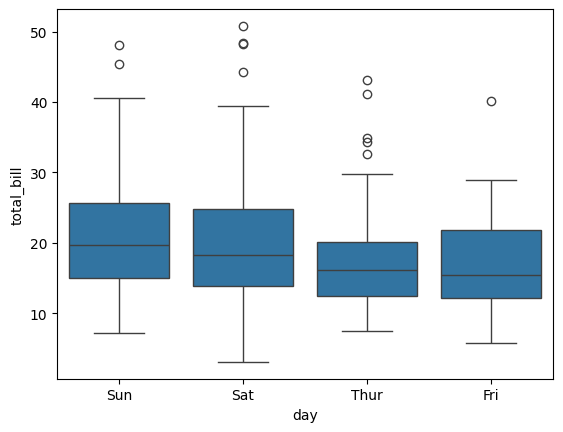

In [16]:
sns.boxplot(data=df, y="total_bill", x="day");

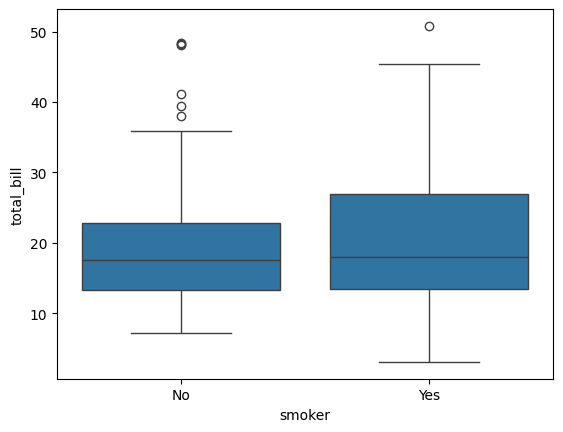

In [17]:
sns.boxplot(data=df, y="total_bill", x="smoker");

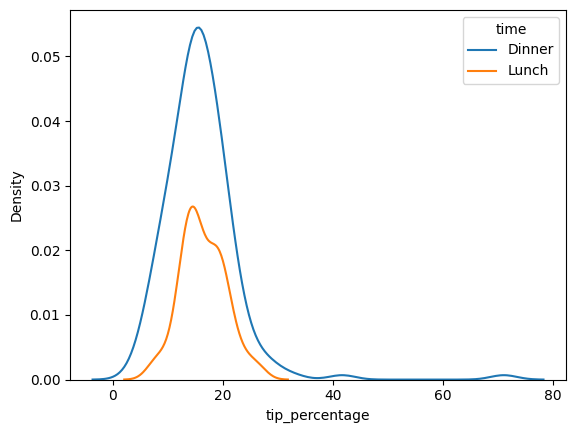

In [18]:
# sns.histplot(data=df, x="tip_percentage", hue="time", binwidth=1);
ax = sns.kdeplot(data=df, x="tip_percentage", hue="time");

In [19]:
df.groupby("time")["tip_percentage"].mean()

time
Dinner    15.951477
Lunch     16.411765
Name: tip_percentage, dtype: float64

<Axes: xlabel='total_bill', ylabel='Density'>

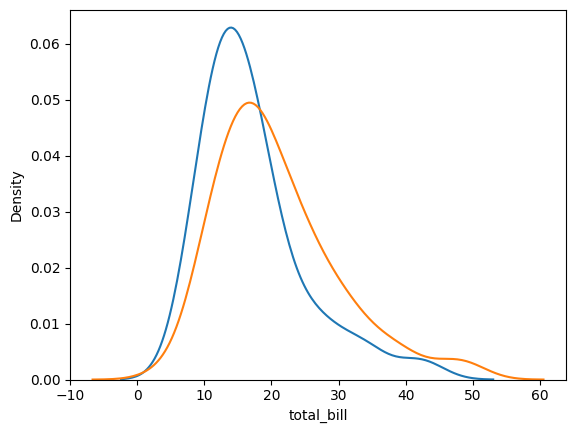

In [20]:
t1 = df[df["time"] == "Lunch"]
t2 = df[df["time"] == "Dinner"]
sns.kdeplot(data=t1, x= "total_bill")
sns.kdeplot(data=t2, x= "total_bill")

<Axes: xlabel='tip_percentage', ylabel='Density'>

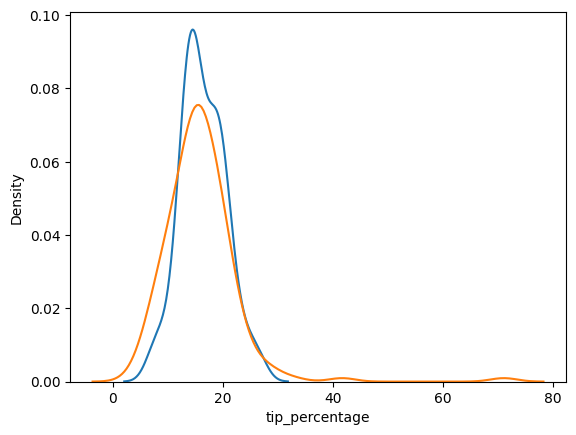

In [21]:
sns.kdeplot(data=t1, x= "tip_percentage")
sns.kdeplot(data=t2, x= "tip_percentage")

<Axes: xlabel='tip_percentage', ylabel='Density'>

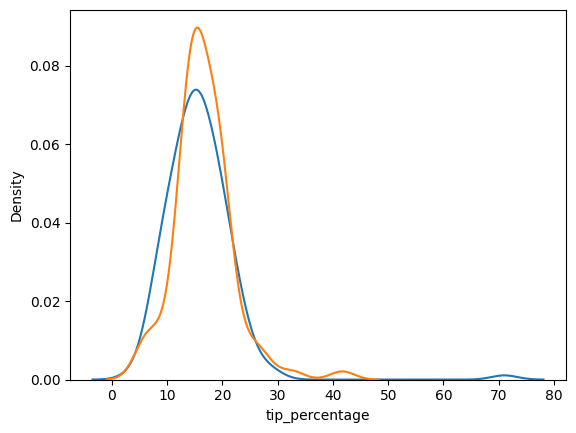

In [22]:
t1 = df[df["sex"] == "Male"]
t2 = df[df["sex"] == "Female"]
sns.kdeplot(data=t1, x= "tip_percentage")
sns.kdeplot(data=t2, x= "tip_percentage")

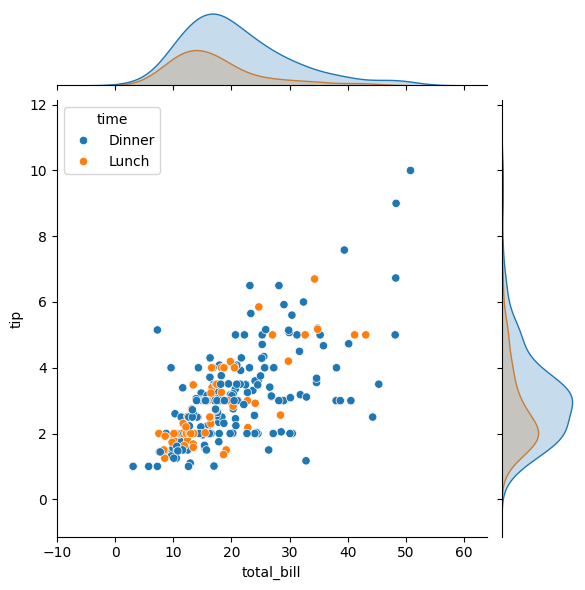

In [23]:
sns.jointplot(data=df, x="total_bill", y="tip", hue="time")

# ML Model

In [24]:
def ml_model(X_train, X_test, y_train, y_test):
    models = [
        ('Linear Regression', LinearRegression()),
        ('Ridge', Ridge()),
        ('Lasso', Lasso()),
        ('Decision Tree Regressor', DecisionTreeRegressor()),
        ('K Neighbors Regressor', KNeighborsRegressor()),
        ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
        ('SVR', SVR()),
        ("XGBRegressor", xgb.XGBRegressor())
    ]
    
    results = []


    for model_name, model in models:
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)

        result = {
            'Model': model_name,
            'r2': r2,
            'mse': mse,
            'rmse': rmse
        }
        results.append(result)

    return results

In [25]:
X = df.drop(columns=["tip_percentage", "tip"])
Y = df["tip"]

bool_col = ["sex", "smoker", "time"]
dummy_col = ["day"]

for col in bool_col:
    X[col] = LabelEncoder().fit_transform(X[col])

X = pd.concat((X, (pd.get_dummies(X["day"], drop_first=True, dtype=int))), axis=1)
X.drop(columns=["day"], inplace=True)
X

,total_bill,sex,smoker,time,size,Sat,Sun,Thur
0,16.99,0,0,0,2,0,1,0
1,10.34,1,0,0,3,0,1,0
2,21.01,1,0,0,3,0,1,0
3,23.68,1,0,0,2,0,1,0
4,24.59,0,0,0,4,0,1,0
...,...,...,...,...,...,...,...,...
239,29.03,1,0,0,3,1,0,0
240,27.18,0,1,0,2,1,0,0
241,22.67,1,1,0,2,1,0,0
242,17.82,1,0,0,2,1,0,0


In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state =2, test_size = 0.2)

mms = MinMaxScaler()
cols = ["total_bill"]
x_train[cols] = mms.fit_transform(x_train[cols])

x_test[cols] = mms.transform(x_test[cols])

res = ml_model(x_train, x_test, y_train, y_test)

In [27]:
pd.DataFrame(res).sort_values("rmse")

,Model,r2,mse,rmse
5,Random Forest Regressor,0.637362,0.799450,0.894119
0,Linear Regression,0.562091,0.965385,0.982540
1,Ridge,0.535253,1.024551,1.012201
6,SVR,0.350823,1.431134,1.196300
7,XGBRegressor,0.341916,1.450771,1.204479
4,K Neighbors Regressor,0.321416,1.495964,1.223096
3,Decision Tree Regressor,0.097881,1.988755,1.410232
2,Lasso,-0.028958,2.268377,1.506113


In [29]:
model = RandomForestRegressor(random_state=42)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

In [34]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
feature_imp_df

,Feature,Gini Importance
0,total_bill,0.773547
4,size,0.060635
2,smoker,0.059479
5,Sat,0.032145
6,Sun,0.027644
1,sex,0.022916
3,time,0.013088
7,Thur,0.010546


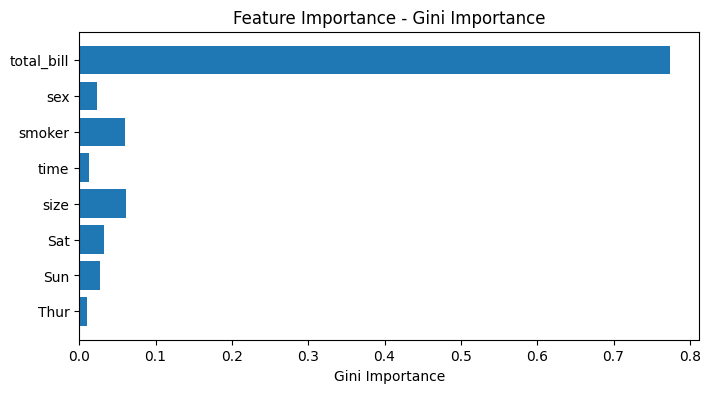

In [36]:
plt.figure(figsize=(8, 4))
plt.barh(X.columns, importances)
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  
plt.show()

In [39]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow

In [47]:
X = sm.add_constant(df['total_bill'])
y = df['tip']
model = sm.OLS(y, X).fit()
rainbow_statistic, rainbow_p_value = linear_rainbow(model)

linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
linear_score = r2_score(y_test, linear_model.predict(x_test))

In [48]:
print("\nLinearity Analysis Results:")
print(f"Rainbow Test Statistic: {rainbow_statistic:.4f}")
print(f"Rainbow Test p-value: {rainbow_p_value:.4f}")
print(f"\nLinear Model R² Score: {linear_score:.4f}")


Linearity Analysis Results:
Rainbow Test Statistic: 1.2291
Rainbow Test p-value: 0.1291

Linear Model R² Score: 0.5621


In [50]:
numeric_data = df[['total_bill', 'tip', 'size']]

print("\nStatistical Measures:")
print("Skewness:")
print(numeric_data.skew())
print("\nKurtosis:")
print(numeric_data.kurtosis())


Statistical Measures:
Skewness:
total_bill    1.133213
tip           1.465451
size          1.447882
dtype: float64

Kurtosis:
total_bill    1.218484
tip           3.648376
size          1.731700
dtype: float64


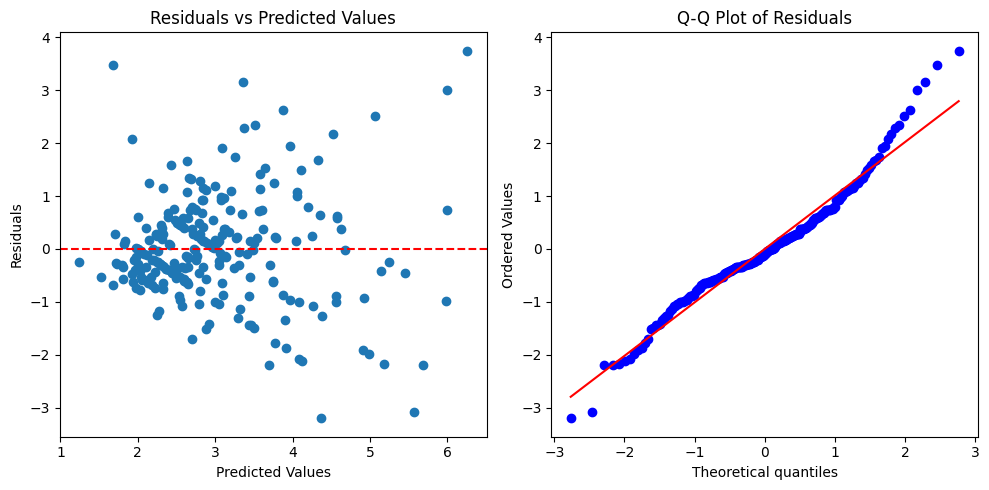

In [53]:
def plot_residuals(X, y):
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    predictions = model.predict(X.reshape(-1, 1))
    residuals = y - predictions
    
    plt.figure(figsize=(10, 5))
    
    # Residuals vs Predicted
    plt.subplot(121)
    plt.scatter(predictions, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Values')
    
    # Q-Q Plot
    plt.subplot(122)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    
    plt.tight_layout()
    plt.show()

plot_residuals(df['total_bill'].values, df['tip'].values)

The results of the linear regression suggest that total bill and group size are significant predictors of tip amounts, while other factors—such as sex, smoking status, day, and time—do not have a substantial effect. With an  R^2  value of 0.637, the model explains about 63.7% of the variation in tips, indicating room for improvement. According to the model, the restaurant could potentially increase tips by encouraging larger groups or higher bills, as these factors are positively associated with tipping, whereas demographics and timing seem to have minimal impact